# Prediction of Fatal Heart Failure Incidents


See eda notebook for exploratory data analysis and description of question at hand. 
Data can be downloaded at Kaggle:
https://www.kaggle.com/andrewmvd/heart-failure-clinical-data


Thanks to the authors of the following paper for making the dataset available on kaggle:
Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). 

In [ ]:
#Info on author of this notebook
__author__ = "Karin Pietruska"
__email__ = "karin.pietruska@gmail.com"

## - Part 5 - Model Development and Evaluation

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve

### Load Data

In [2]:
path = "data/"
filename = "heart_failure_clinical_records_dataset.csv"
df_hrdata = pd.read_csv(path + filename)

In [3]:
# identify categorical features, continuous features and target variable
cat_features = ["anaemia","diabetes","high_blood_pressure","sex","smoking"]
con_features = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]
all_features = df_hrdata.columns[df_hrdata.columns != "DEATH_EVENT"].tolist()
target = "DEATH_EVENT"
print(all_features)

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']


In [4]:
# convert the int64 data types of categorical variables to boolean
target_list=[target]
df_hrdata[cat_features + target_list] = df_hrdata[cat_features + target_list].astype(bool)
df_hrdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    bool   
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    bool   
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    bool   
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    bool   
 10  smoking                   299 non-null    bool   
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    bool   
dtypes: bool(6), float64(3), int64(4)
memory usage: 18.2 KB


### Preprocess Data for Model Development

In [5]:
def standardize_data(df, numerical_vars):
    """ standardize numerical columens with z-score method of StandardScaler"""
    std_scaler = StandardScaler()
    std_scaler
    df[numerical_vars] = pd.DataFrame(std_scaler.fit_transform(df[numerical_vars]))
    

def normalize_data_minmax(df, numerical_vars):
    """ standardize numerical columens with z-score method of StandardScaler"""
    minmax_scaler = MinMaxScaler()
    minmax_scaler
    df[numerical_vars] = pd.DataFrame(minmax_scaler.fit_transform(df[numerical_vars]))

In [6]:
standardize_data(df_hrdata, con_features)
df_hrdata.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.192945,False,0.000166,False,-1.530560,True,1.681648e-02,0.490057,-1.504036,True,False,-1.629502,True
1,-0.491279,False,7.514640,False,-0.007077,False,7.535660e-09,-0.284552,-0.141976,True,False,-1.603691,True
2,0.350833,False,-0.449939,False,-1.530560,False,-1.038073e+00,-0.090900,-1.731046,True,True,-1.590785,True
3,-0.912335,True,-0.486071,False,-1.530560,False,-5.464741e-01,0.490057,0.085034,True,False,-1.590785,True
4,0.350833,True,-0.435486,True,-1.530560,False,6.517986e-01,1.264666,-4.682176,False,False,-1.577879,True


In [7]:
# divide data into train and test set (split 80 to 20%)
train_df, test_df = train_test_split(df_hrdata, test_size=0.3, random_state = 13)

In [8]:
train_df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
17,-1.333392,False,0.000166,False,-2.038387,False,-9.971065e-01,-0.575031,-2.185066,True,False,-1.500444,True
157,-0.912335,False,-0.342574,False,-1.107370,False,-1.390846e-02,-0.381379,-0.141976,True,True,-0.132425,False
92,-1.586025,False,0.000166,False,1.854958,False,7.535660e-09,-0.207091,0.085034,False,False,-0.622847,False
142,-0.912335,False,-0.103069,True,-0.684180,False,6.722819e-01,-0.478205,-1.050016,False,False,-0.274389,False
218,0.603467,True,0.453367,True,-0.260991,False,7.826636e-02,-0.284552,-0.595996,True,False,0.861324,False


In [9]:
len(train_df)

209

In [10]:
test_df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
263,0.603467,True,-0.438583,True,1.854958,False,-5.669574e-01,-0.381379,0.766064,False,False,1.377558,False
118,0.350833,True,-0.484006,True,1.854958,True,-6.181656e-01,-0.478205,0.766064,False,False,-0.467977,False
197,0.350833,False,-0.428259,False,-0.684180,False,-4.463340e-02,-0.575031,0.312044,False,False,0.719360,False
80,0.771889,False,-0.529430,False,0.162199,False,3.035826e-01,0.296405,-0.141976,False,False,-0.713188,False
30,2.792959,False,0.000166,True,-0.007077,True,7.535660e-09,0.422279,-0.595996,True,False,-1.332668,True


In [11]:
len(test_df)

90

In [12]:
# shuffle data in train df 
train_df = shuffle(train_df)

In [13]:
train_target_ser = train_df[target]
train_features_df = train_df.drop(target, axis=1)

In [14]:
train_features_df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
110,2.035057,False,-0.467489,False,1.854958,False,4.367240e-01,-0.187726,-1.050016,True,True,-0.519600
292,-0.743913,False,-0.404515,True,-0.007077,False,1.215089e+00,-0.381379,0.766064,True,True,1.648581
199,-0.070223,False,0.649514,True,-0.260991,False,7.535660e-09,0.393231,-5.363206,True,True,0.719360
202,0.771889,False,-0.500524,False,1.854958,True,-4.440576e-01,-0.478205,0.312044,True,False,0.719360
204,1.445579,True,-0.534591,False,0.162199,False,1.397162e-01,-0.671857,0.085034,True,True,0.732266


In [15]:
train_target_ser.head(5)

110     True
292    False
199    False
202    False
204    False
Name: DEATH_EVENT, dtype: bool

In [16]:
test_target_ser = test_df[target]
test_features_df = test_df.drop(target, axis=1)

### Model Development and Evaluation

### - Base Model - Logistic Regression

In [17]:
# default parameters
logreg = LogisticRegression()

logreg.fit(train_features_df, train_target_ser)

LogisticRegression()

In [18]:
y_train_pred = logreg.predict(train_features_df)

In [19]:
y_train_pred_df = pd.DataFrame(y_train_pred)

In [20]:
# Use score method to get accuracy of model
score = logreg.score(train_features_df, train_target_ser)
print(score)

0.8373205741626795


In [21]:
y_test_pred = logreg.predict(test_features_df)

In [22]:
y_test_pred_df = pd.DataFrame(y_test_pred)

In [23]:
# Use score method to get accuracy of model
score = logreg.score(test_features_df, test_target_ser)
print(round(score,4))

0.8111


In [24]:
cm = confusion_matrix(test_target_ser, y_test_pred_df)
print(cm)

[[57  5]
 [12 16]]


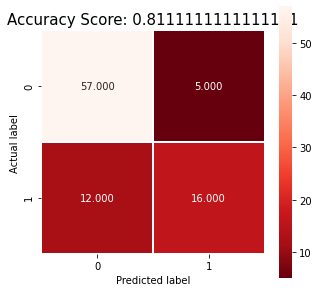

In [25]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

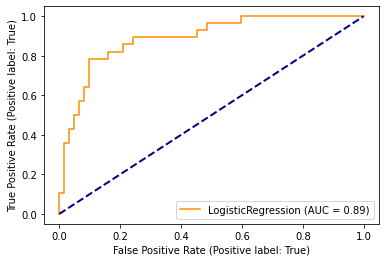

In [26]:
lw=2
rfc_disp = plot_roc_curve(logreg, test_features_df,test_target_ser, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

In [27]:
logreg.coef_

array([[ 0.59961902,  0.25116874,  0.17150286,  0.45378632, -0.65623627,
        -0.06662303, -0.15678606,  0.65314167, -0.41272387, -0.26937275,
        -0.0383636 , -1.45725277]])

In [28]:
def visualize_coefficients(classifier, feature_names):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    # plot them
    plt.figure(figsize=(15, 5))
    
    feature_names = np.array(feature_names)
    plt.bar(feature_names, coef)
    plt.xticks(rotation=90)
    plt.ylabel('parameter weitght values')
    plt.show()
    

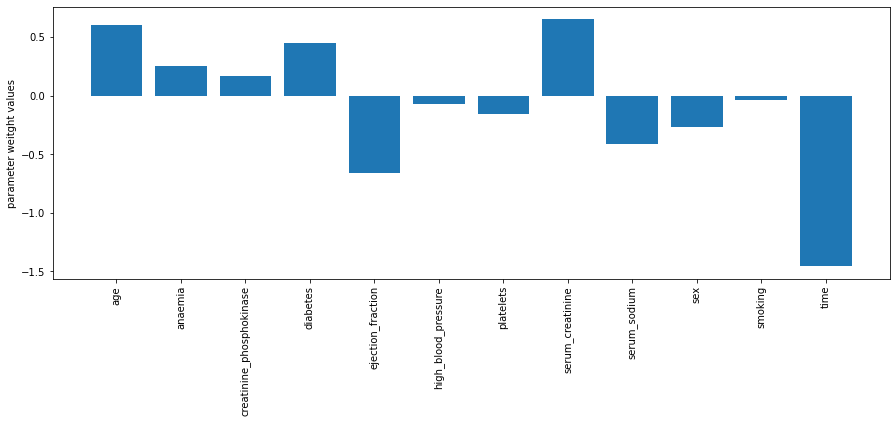

In [29]:
visualize_coefficients(logreg, all_features)

### Logistic Regression and Random Forest Classifier - Hyperparameter Tuning 

In [30]:
# Create a pipeline

pipe = Pipeline([('classifier',LogisticRegression())])


# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l2'],
                 'classifier__C': [0.01, 0.8, 1.0, 2.0, 5.0, 10.0, 25.0],
                },
               
                {'classifier': [RandomForestClassifier(random_state=2)],
                 'classifier__n_estimators': list(range(10, 150, 10)),
                 'classifier__max_depth': [4,8,12,16,20,30,32, None],
                 'classifier__max_features': list(range(1,12,1)),
                 'classifier__min_samples_split':[2,4,6,8]}
                 ]

In [31]:
# Create grid search 
gridsearch = GridSearchCV(pipe, search_space, cv=2, verbose=1, scoring='accuracy')

In [32]:
gridsearch.fit(train_features_df, train_target_ser)

Fitting 2 folds for each of 4935 candidates, totalling 9870 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.01, 0.8, 1.0, 2.0, 5.0, 10.0,
                                            25.0],
                          'classifier__penalty': ['l2']},
                         {'classifier': [RandomForestClassifier(max_depth=4,
                                                                max_features=4,
                                                                random_state=2)],
                          'classifier__max_depth': [4, 8, 12, 16, 20, 30, 32,
                                                    None],
                          'classifier__max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11],
                          'classifier__min_samples_split': [2, 4, 6, 8],
                          'classifier__n_estimators': [10,

In [33]:
# parameters of best estimator
gridsearch.best_estimator_.get_params()['classifier']

RandomForestClassifier(max_depth=4, max_features=4, random_state=2)

In [34]:
# best accuracy score during training 
gridsearch.best_score_

0.8469322344322344

In [35]:
y_train_pred = gridsearch.best_estimator_.predict(train_features_df)

In [36]:
y_test_pred = gridsearch.best_estimator_.predict(test_features_df)

In [37]:
# New Model Evaluation metrics 
print('Test Accuracy Score : ' + str(accuracy_score(test_target_ser,y_test_pred)))
print('Test Precision Score : ' + str(precision_score(test_target_ser,y_test_pred)))
print('Test Recall Score : ' + str(recall_score(test_target_ser,y_test_pred)))
print('Test F1 Score : ' + str(f1_score(test_target_ser,y_test_pred)))

Test Accuracy Score : 0.8777777777777778
Test Precision Score : 0.9047619047619048
Test Recall Score : 0.6785714285714286
Test F1 Score : 0.7755102040816326


In [38]:
cm = confusion_matrix(test_target_ser, y_test_pred)

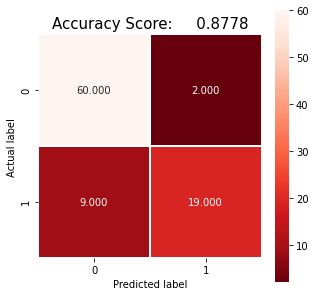

In [39]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:10.4f}'.format(accuracy_score(test_target_ser,y_test_pred))
plt.title(all_sample_title, size = 15);

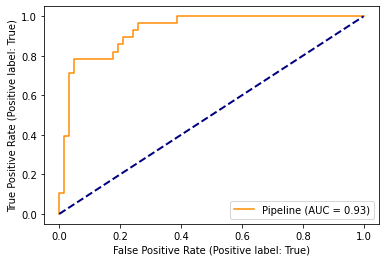

In [40]:
rfc_disp = plot_roc_curve(gridsearch.best_estimator_, test_features_df,test_target_ser, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')